# Extracción y regulación de las series.
El objetivo de este notebook es regularizar las series de tiempo de nuestro dataset. Para ello, consideraremos en primera instancia una interpolación lineal.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from tqdm.auto import tqdm # Para la barra de progreso
import time 
import traces
import datetime
from datetime import timedelta
from processing import * #Esto tiene las funciones definidas más abajo
import warnings
import random 
from scipy.interpolate import interp1d


La primera parte será cargar los datos

In [227]:
gen_path = 'C:/Users/rauls/OneDrive/DataScience/Proyecto/alcock' #Este es el path general
df = read_df(gen_path)
paths = df['Path']
number_of_objects = df.shape[0]
df

,ID,Class,Path,Band
0,1.3441.1031,RRab,1.3441.1031.dat,1.0
1,1.3442.503,RRab,1.3442.503.dat,1.0
2,1.3442.1051,RRab,1.3442.1051.dat,1.0
3,1.3442.1107,RRab,1.3442.1107.dat,1.0
4,1.3442.1243,RRab,1.3442.1243.dat,1.0
...,...,...,...,...
7392,9.5607.1084,RRab,9.5607.1084.dat,1.0
7393,9.5608.870,RRab,9.5608.870.dat,1.0
7394,9.5608.946,RRab,9.5608.946.dat,1.0
7395,9.5609.790,RRab,9.5609.790.dat,1.0


In [266]:
# objects = get_objects(df, gen_path, number_of_objects)
objects = get_objects(df, gen_path, 30) #poner el numero de objetos que queremos cargar, number_of_objects para el total

  0%|          | 0/7397 [00:00<?, ?it/s]

Por ejemplo, el dataset tiene estos elementos. Le incluimos la columna en iso

In [267]:
objects[paths[4]]

,mjd,mag,err,iso
0,48824.63281,-5.299,0.090,1992-07-21 15:11:14.784
1,48824.64453,-5.326,0.086,1992-07-21 15:28:07.392
2,48825.64844,-5.005,0.099,1992-07-22 15:33:45.216
3,48825.66016,-5.171,0.090,1992-07-22 15:50:37.824
4,48825.66797,-5.055,0.099,1992-07-22 16:01:52.608
...,...,...,...,...
410,51510.65234,-4.990,0.040,1999-11-28 15:39:22.176
411,51513.50000,-5.048,0.038,1999-12-01 12:00:00.000
412,51514.66016,-5.100,0.058,1999-12-02 15:50:37.824
413,51526.52344,-5.024,0.036,1999-12-14 12:33:45.216


Ahora mostramos como obtener serie regular obtenida por interpolacion lineal.

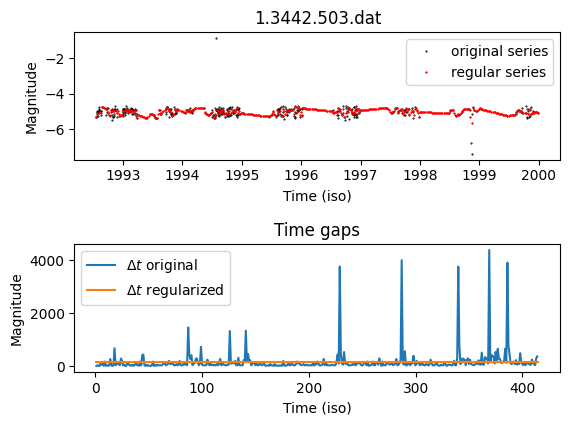

In [268]:
data = objects[paths[4]] #Consideremos esta serie
regular = get_regular_linear_interpolation(data) #esta es su version regular
plot_everything(data, paths[1]) #y aquí está todo ploteado


In [269]:
from astropy.timeseries import LombScargle

def estimate_period(path, plot = False):
    times = objects[path]['mjd'].values
    magnitudes = objects[path]['mag'].values
    frequency, power = LombScargle(times, magnitudes).autopower(method='fastchi2')
    period = 1/frequency[np.argmax(power)] 
    if plot:
        plt.figure(figsize=(5,2))
        plt.plot(frequency, power)
    return period

In [270]:
def get_folded_curve(path, plot = False):
    period = estimate_period(path)
    times = objects[path]['mjd'].values
    magnitudes = objects[path]['mag'].values
    phases = (times%period)/period
    indices = np.argsort(phases)
    values_sorted = magnitudes[indices]
    phases_sorted = phases[indices]
    
    f= interp1d(np.concatenate([phases_sorted, phases_sorted+1]), np.concatenate([values_sorted, values_sorted]))
    regular_curve_phased = np.linspace(min(phases), max(phases), len(phases))

    if plot:
        fig, axes = plt.subplots(3,1, figsize=(8,6))
        fig.tight_layout(pad=4.0)
        axes[0].plot(times, magnitudes)
        axes[1].plot(np.concatenate([phases_sorted, phases_sorted+1]), np.concatenate([values_sorted, values_sorted]))
        axes[0].set_title(path)
        axes[0].set(xlabel="Time (mjd)", ylabel="Magnitude")
        axes[1].set(xlabel="Phase", ylabel="Magnitude")
        axes[1].set_title('Phased ' + path)
        axes[2].set_title('Regular Phased ' + path)
        axes[2].plot(np.concatenate([regular_curve_phased, regular_curve_phased+1]), f(np.concatenate([regular_curve_phased, regular_curve_phased+1])), '*r')
        plt.show()
        
    return phases_sorted, values_sorted, regular_curve_phased, f(regular_curve_phased)

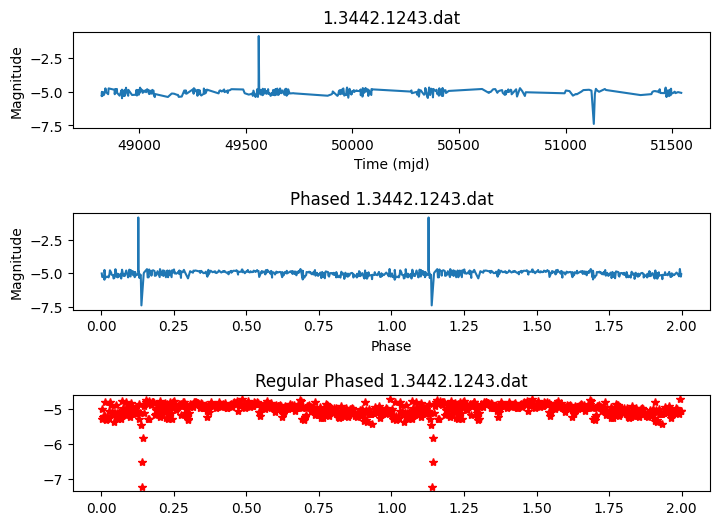

In [271]:
curve_phased, magn_phased, regular_curve_phased, regular_curve_magn = get_folded_curve(paths[4], True)

Ahora vamos a guardar las series regulares, y las series en el diagrama de fases regulares.

In [273]:
objects = dict()
inicio = time.time() #Iniciamos la medición del tiempo d
regular_ts = dict()
phases = dict()
regular_phases = dict()
paths = df['Path']
tol = 30 #Cambiar aquí por la cantidad de series a guardar
for i in tqdm(range(len(paths))): 
    if i>= tol:
        break
    time.sleep(0.001)
    path = paths[i]
    datos = pd.read_csv(gen_path + '/LCs/' + path) #Se leen los datos
    objects[path] = add_iso_time(datos) #Se guarda con la columna iso en objects
    regular = get_regular_linear_interpolation(objects[path]) #la regular que se obtiene por interpolacion
    regular_ts[path] = regular  #se guarda en el diccionario regular_ts
    curve_phased, magn_phased, regular_curve_phased, regular_curve_magn = get_folded_curve(path) #obtenemos en fase, y el fase regular
    phased = pd.DataFrame() 
    phased['phase'] = curve_phased 
    phased['mag'] = magn_phased 
    regular_phased = pd.DataFrame()
    regular_phased['phase'] = regular_curve_phased 
    regular_phased['mag'] = regular_curve_magn 
    phases[path] = phased
    regular_phases[path] = regular_phased #Los guardamos como dataframe en sus reps. diccionarios.
    
    regular.to_pickle(path + '_regular.pkl') #y los descargamos (los regulares. como pkl)
    regular_phased.to_pickle(path + '_regular_phased.pkl')
    phased.to_pickle(path + '_phased.pkl') #Tambien el fase no regular
    
fin = time.time()
print('Running time: ' + str(fin-inicio) + ' segundos.'+'\n')

  0%|          | 0/7397 [00:00<?, ?it/s]

Running time: 16.106311559677124 segundos.



In [275]:
#Ahora vamos a cargar los dataframes regulares
regulares = dict()
regular_phases = dict()
tol = 20
for i in tqdm(range(len(paths))):
    if i>=tol:
        break
    time.sleep(0.001)
    path = paths[i]
    datos1 = pd.read_pickle('C:/Users/rauls/OneDrive/DataScience/Proyecto/RRab_regulares/' + path + '_regular.pkl')
    datos2 = pd.read_pickle('C:/Users/rauls/OneDrive/DataScience/' + path + '_regular_phased.pkl')
    regulares[path] = datos1
    regular_phases[path] = datos2

  0%|          | 0/7397 [00:00<?, ?it/s]

In [276]:
#Para cargarlos, por ejemplo 
regular_phases[paths[0]]

,phase,mag
0,0.002815,-5.307000
1,0.006126,-5.170330
2,0.009437,-5.033660
3,0.012748,-5.282510
4,0.016059,-5.415955
...,...,...
297,0.986176,-5.207279
298,0.989487,-5.140611
299,0.992798,-5.430905
300,0.996109,-5.167452
